In [1]:
import pandas as pd
import os
import glob
import dask.dataframe as dd
from dask import delayed
import numpy as np
@delayed
def process_file(file):
    df = pd.read_csv(file, index_col=0)
    df['TF'] = file.split('_')[-2]
    df['gender'] = file.split('_')[-3]
    df['term_idname'] = df['term_id'] + '_' + df['term_name']
    return df

/tmp/ipykernel_3586865/2506564632.py:4: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via CLI
    dask config set dataframe.query-p

In [2]:
df_moudule =  '/data2st1/junyi/output/atac0627/snregulation/genemodule_new.csv'
outdir ='/data2st1/junyi/output/atac0627/snregulation/gostmodule_new'
df_TFstata = '/data1st1/yejun/long_neglog10p_merge.csv'
df_glob = glob.glob('/data2st1/junyi/output/atac0627/snregulation/gost/_GO*.csv')
meta=pd.read_csv('/data2st1/junyi/data/L2_anno_meta_add_mementovsmast.csv')
meta['celltype.L2'] = meta['L2'].str.replace(' ','_').str.replace('/','_')
l2nntype = dict(zip( meta['celltype.L2'],meta['Neurotransmitter_celltype']))
df_TF = pd.read_csv(df_moudule, index_col=0)

In [3]:
df_TF

,module
TF,
Cux1,1
Tef,1
Srebf2,1
Zeb1,1
Foxp1,1
...,...
Supt20,6
Junb,7
Egr4,7


In [4]:
df_TF_stata = pd.read_csv(df_TFstata, index_col=0)

In [5]:
df_TF_stata

,TF,celltype,nlog10_p_val_adj
1,1810024B03Rik,AMY,0.022958
2,1810024B03Rik,AMY_Ccdc3_Acvr1c_Glut_F,0.000000
3,1810024B03Rik,AMY_Ccdc3_Acvr1c_Glut_M,0.000000
4,1810024B03Rik,AMY_Cdh23_Hmcn1_Glut_F,0.000000
5,1810024B03Rik,AMY_Cdh23_Hmcn1_Glut_M,0.000000
...,...,...,...
703656,Zxdc,VLMC-2_M,0.000000
703657,Zxdc,VLMC-3_F,0.000000
703658,Zxdc,VLMC-3_M,-1.414311
703659,Zxdc,VSMC_F,-0.079969


In [6]:
# only select row in df_TF
df_TF_stata = df_TF_stata[df_TF_stata['TF'].isin(df_TF.index)]
#df_TF_stata['status'] = df_TF_stata['nlog10_p_val_adj'].sign() ,status is the 1 of the nlog10_p_val_adj > 0.05, -1 of the nlog10_p_val_adj < 0.05
df_TF_stata['status'] = np.sign(df_TF_stata['nlog10_p_val_adj'])
df_TF_stata = df_TF_stata.merge(df_TF, on='TF', how='left')
df_modulestat = df_TF_stata.groupby(['module','celltype']).aggregate({'nlog10_p_val_adj': 'mean', 'status': 'sum'}).reset_index()
df_modulestat['regulation'] = 0
df_modulestat.loc[df_modulestat['status'] > 0, 'regulation'] = 1
df_modulestat.loc[df_modulestat['status'] < 0, 'regulation'] = -1

/tmp/ipykernel_3586865/3103431475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TF_stata['status'] = np.sign(df_TF_stata['nlog10_p_val_adj'])


In [9]:
df_modulestat

,module,celltype,nlog10_p_val_adj,status,regulation
0,1,AMY,19.470657,21.0,1
1,1,AMY_Ccdc3_Acvr1c_Glut_F,0.857519,9.0,1
2,1,AMY_Ccdc3_Acvr1c_Glut_M,-0.218659,-3.0,-1
3,1,AMY_Cdh23_Hmcn1_Glut_F,0.644861,10.0,1
4,1,AMY_Cdh23_Hmcn1_Glut_M,0.881357,13.0,1
...,...,...,...,...,...
3257,7,VLMC-2_M,2.227248,4.0,1
3258,7,VLMC-3_F,-0.120550,-2.0,-1
3259,7,VLMC-3_M,1.185547,3.0,1
3260,7,VSMC_F,-2.191761,-4.0,-1


In [11]:
df_modulestat

,module,celltype,nlog10_p_val_adj,status,regulation
0,1,AMY,19.470657,21.0,1
1,1,AMY_Ccdc3_Acvr1c_Glut_F,0.857519,9.0,1
2,1,AMY_Ccdc3_Acvr1c_Glut_M,-0.218659,-3.0,-1
3,1,AMY_Cdh23_Hmcn1_Glut_F,0.644861,10.0,1
4,1,AMY_Cdh23_Hmcn1_Glut_M,0.881357,13.0,1
...,...,...,...,...,...
3257,7,VLMC-2_M,2.227248,4.0,1
3258,7,VLMC-3_F,-0.120550,-2.0,-1
3259,7,VLMC-3_M,1.185547,3.0,1
3260,7,VSMC_F,-2.191761,-4.0,-1


In [10]:
modules = df_TF['module'].unique()

for module in modules:
    TF_module = df_TF[df_TF.module==module]
    # subset the file tha contains any tf in TFmodule.index
    filtered_list = [file for file in df_glob if any(tf in file for tf in TF_module.index)]

    # Create list of delayed objects
    delayed_dfs = [process_file(file) for file in filtered_list]

    # Convert to Dask DataFrame
    ddf = dd.from_delayed(delayed_dfs)

    # Compute result
    df_go_module = ddf.compute()

    df_go_module_group = df_go_module.groupby(['term_name','celltype','gender']).size().reset_index(name='count')
    df_go_module_group['celltype.gender'] = df_go_module_group['celltype'] + '_' + df_go_module_group['gender']
    df_go_module_group['module'] = module
    df_go_module_group =df_go_module_group.merge(df_modulestat, left_on=['celltype.gender','module'],right_on=['celltype','module'], how='left')
    df_go_module_group['reg_count'] = df_go_module_group['count'] * df_go_module_group['regulation']
    df_go_module_group.to_csv(os.path.join(outdir, f'{module}_gosummary.csv'), index=False)

In [26]:
module_go = glob.glob(f"/data2st1/junyi/output/atac0627/snregulation/gostmodule_new/*GO_enrich*TFmoudule*csv")

for module in modules:
    modulestr = 'TFmoudule'+str(module)
    #TF_module = df_TF[df_TF.module==module]
    # subset the file tha contains any tf in TFmodule.index
    filtered_list = [file for file in module_go if modulestr in file]

    # Create list of delayed objects
    delayed_dfs = [process_file(file) for file in filtered_list]

    # Convert to Dask DataFrame
    ddf = dd.from_delayed(delayed_dfs)

    # Compute result
    df_go_module = ddf.compute()

#     df_go_module_group = df_go_module.groupby(['term_name','celltype','gender']).size().reset_index(name='count')
#     df_go_module_group['celltype.gender'] = df_go_module_group['celltype'] + '_' + df_go_module_group['gender']
#     df_go_module_group['module'] = module
#     df_go_module_group =df_go_module_group.merge(df_modulestat, left_on=['celltype.gender','module'],right_on=['celltype','module'], how='left')
#     df_go_module_group['reg_count'] = df_go_module_group['count'] * df_go_module_group['regulation']
    df_go_module.to_csv(os.path.join(outdir, f'TFmodule{module}_gosummary.csv'), index=False)

In [ ]:
# !source /home/junyichen/anaconda3/etc/profile.d/conda.sh
# !conda activate snap
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule1_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule2_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule3_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule4_gosummary.csv ;
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule5_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule6_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule7_gosummary.csv |\
# !python testclf.py --csv_test_path /data2st1/junyi/output/atac0627/snregulation/gosummary_module/TFmodule8_gosummary.csv ;


CondaError: Run 'conda init' before 'conda activate'

/bin/bash: line 1: !python: command not found
/bin/bash: line 1: !python: command not found
/bin/bash: line 1: !python: command not found
Traceback (most recent call last):
  File "/home/junyichen/code/scmmd/testclf.py", line 124, in <module>
    classifiers = train_go_classifier(csv_path)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/junyichen/code/scmmd/testclf.py", line 83, in train_go_classifier
    print("Module Classification Report:")
BrokenPipeError: [Errno 32] Broken pipe
/bin/bash: line 1: !python: command not found
/bin/bash: line 1: !python: command not found
/bin/bash: line 1: !python: command not found
Traceback (most recent call last):
  File "/home/junyichen/code/scmmd/testclf.py", line 124, in <module>
    classifiers = train_go_classifier(csv_path)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/junyichen/code/scmmd/testclf.py", line 83, in train_go_classifier
    print("Module Classi

In [30]:
df_moudule1 = pd.read_csv("/data2st1/junyi/output/atac0627/snregulation/gostmodule_new/TFmodule1_gosummary.csv.predicted.csv")

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
df_moudule1

,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,...,parents,evidence_codes,intersection,celltype,gene_type_group,TF,gender,term_idname,clean_go_term,predicted_module
0,True,2.342199e-22,13503,377,294,0.779841,0.021773,GO:0065007,GO:BP,biological regulation,...,GO:0008150,"IDA IPI IMP IGI ISO IBA IEA,IMP IEA,IEA,IBA IE...","Map2k6,Frmd4a,Daam1,Smurf2,Ppp2r2b,Bcl11a,Abr,...",STR_D2_GABA,gene,TFmoudule1,F,GO:0065007_biological regulation,go0065007_biological regulation,12
1,True,2.113255e-21,13108,377,287,0.761273,0.021895,GO:0050789,GO:BP,regulation of biological process,...,GO:0008150/GO:0065007,"IDA IPI IMP IGI ISO IBA IEA,IMP IEA,IEA,IBA IE...","Map2k6,Frmd4a,Daam1,Smurf2,Ppp2r2b,Bcl11a,Abr,...",STR_D2_GABA,gene,TFmoudule1,F,GO:0050789_regulation of biological process,go0050789_regulation of biological process,12
2,True,4.834806e-20,12715,377,279,0.740053,0.021943,GO:0050794,GO:BP,regulation of cellular process,...,GO:0009987/GO:0050789,"IDA IPI IMP IGI ISO IBA IEA,IMP IEA,IEA,IBA IE...","Map2k6,Frmd4a,Daam1,Smurf2,Ppp2r2b,Bcl11a,Abr,...",STR_D2_GABA,gene,TFmoudule1,F,GO:0050794_regulation of cellular process,go0050794_regulation of cellular process,12
3,True,4.489225e-19,2593,377,104,0.275862,0.040108,GO:0007399,GO:BP,nervous system development,...,GO:0048731,"IMP,ISO IBA IEA,IGI,IMP,IMP IBA IEA,IMP IGI IB...","Bahcc1,Bcl11a,Abr,Shank2,Dscaml1,Plxna4,Lrrtm3...",STR_D2_GABA,gene,TFmoudule1,F,GO:0007399_nervous system development,go0007399_nervous system development,1
4,True,3.155444e-18,3558,379,124,0.327177,0.034851,GO:0023051,GO:BP,regulation of signaling,...,GO:0023052/GO:0050789,"IDA IMP IGI,IBA IEA,IDA IMP,IMP IEA,IEA,IEA,IM...","Map2k6,Smurf2,Abr,Shank2,Nr3c2,Chn2,Dapk1,Tgfb...",STR_D2_GABA,gene,TFmoudule1,F,GO:0023051_regulation of signaling,go0023051_regulation of signaling,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343755,True,3.740292e-02,42,1599,11,0.006879,0.261905,GO:0140938,GO:MF,histone H3 methyltransferase activity,...,GO:0042054,"IDA ISS IBA,IEA,ISS IEA,IDA IMP IBA IEA,IMP IB...","Setd3,Nsd1,Setmar,Ash1l,Kmt2d,Setbp1,Setd2,Set...",TH_Car4_Tspan11_Glut,gene,TFmoudule1,M,GO:0140938_histone H3 methyltransferase activity,go0140938_histone h3 methyltransferase activity,12
343756,True,3.760909e-02,38,1173,9,0.007673,0.236842,GO:0004712,GO:MF,protein serine/threonine/tyrosine kinase activity,...,GO:0004672,"IEA,IMP,ISO IEA,IEA,IDA IBA IEA,IEA,ISS IEA,IS...","Tesk2,Mapk9,Sgk1,Clk4,Map2k5,Dyrk1a,Pak3,Prkcg...",TH_Car4_Tspan11_Glut,gene,TFmoudule1,M,GO:0004712_protein serine/threonine/tyrosine k...,go0004712_protein serinethreoninetyrosine kina...,12
343757,True,4.139629e-02,125,1477,20,0.013541,0.160000,GO:0042826,GO:MF,histone deacetylase binding,...,GO:0019899,"ISS IBA IEA,ISO,IPI,IEA,IEA,IPI,IEA,IPI IBA,ID...","Mef2a,Runx2,Chd5,Sfpq,Sp2,Jdp2,Nipbl,Mef2c,Mef...",TH_Car4_Tspan11_Glut,gene,TFmoudule1,M,GO:0042826_histone deacetylase binding,go0042826_histone deacetylase binding,12
343758,True,4.167046e-02,1285,1014,83,0.081854,0.064591,GO:0000977,GO:MF,RNA polymerase II transcription regulatory reg...,...,GO:0000976,"IBA,IMP IBA,IDA ISS IBA IEA,IDA IMP IBA,IBA IE...","Zkscan2,Foxp1,Mef2a,Nr6a1,Irf2,Pou2f1,Zfp704,P...",TH_Car4_Tspan11_Glut,gene,TFmoudule1,M,GO:0000977_RNA polymerase II transcription reg...,go0000977_rna polymerase ii transcription regu...,12


In [33]:
df_moudule1['predicted_module'].value_counts()

12    253691
1      33791
3      20569
2      17637
5       8700
9       3298
4       3097
6       1013
10       762
7        660
8        329
11       213
Name: predicted_module, dtype: int64

In [42]:
module_color = {
    1 :'#59F5FD',
    2 :'#D86DCD',
    3 :'#E49EDD',
    4 :'#FFC000',
    5 :'#00B050',
    6 :'#92D050',
    7 :'#83E28E',
    8 :'#4D93D9',
    9 :'#747474',
    10: '#ADADAD',
    11: '#7E350E',
    12: '#BE5014',
    13: '#FFFF00',
    14: '#6666FF',
    15: '#782170',
}


/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


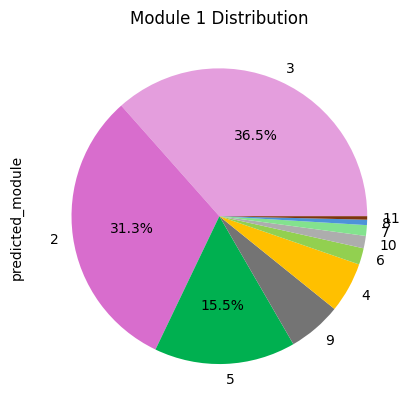

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


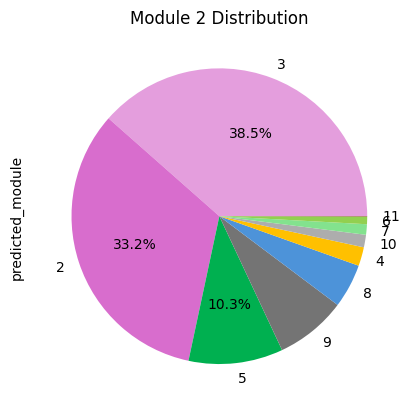

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


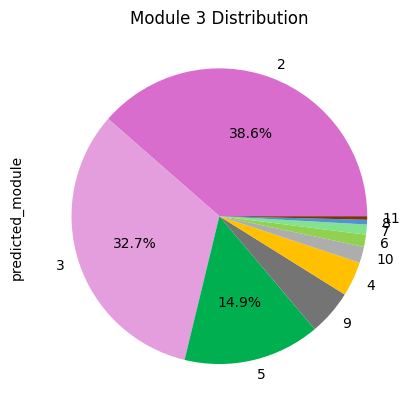

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


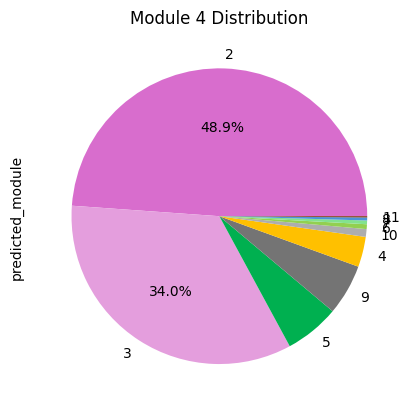

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


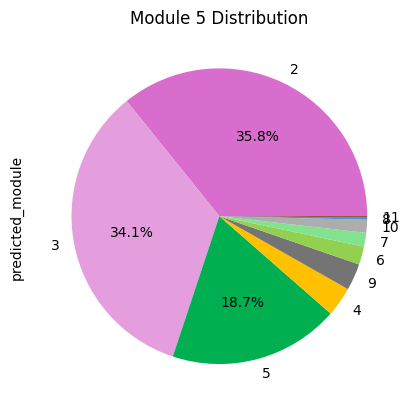

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


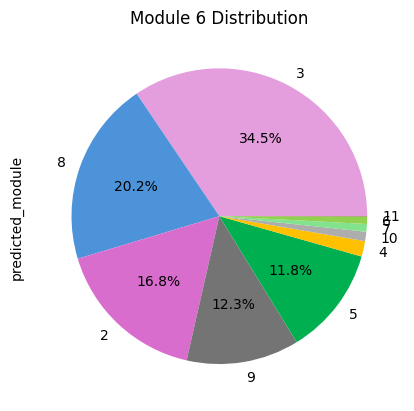

/tmp/ipykernel_3586865/2504079534.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))


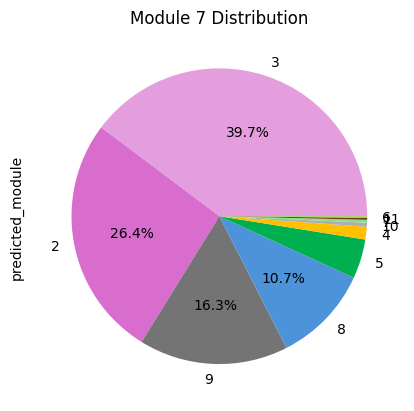

In [ ]:
# # plot the distribution of predicted_module
for module in range(1, 8):
    df_module = pd.read_csv(f"/data2st1/junyi/output/atac0627/snregulation/gostmodule_new/TFmodule{module}_gosummary.csv.predicted.csv")
    # module_count = df_module.groupby(['predicted_module','celltype.gender']).sum()['reg_count'].reset_index()
    df_module_selected = df_module[~df_module['predicted_module'].isin([1,12])]
    df_module_selected['genes'] = df_module_selected['intersection'].apply(lambda x: x.split(','))
    df_module_exp = df_module_selected.explode('genes')
    df_gene_count = df_module_exp.groupby(['predicted_module', 'genes']).nunique()['term_idname'].reset_index()
    df_gene_count.to_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gocount_gene.csv", index=False)

        # write csv
    # module_count.to_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gocount_gropup.csv", index=False)
    # plt.figure(figsize=(10, 5))
    # df_t = df_module.pivot('celltype.gender', 'predicted_module', 'reg_count').T
    # df_t.to_csv(f"/data2st1/junyi/output/atac0627/snregulation/gosummary_module/{module}_gocount_gropup.pivot.csv")
    # sns.heatmap(df_t, cmap='coolwarm', vmax=30, vmin=-30, center=0)
    # plt.show()
    # plt.close()
    # print(df_module[df_module.predicted_module!=12].drop_duplicates('term_name')['predicted_module'].value_counts())
    # plot piechart
    # donnot show percentage if < 10%
    df_module_selected = df_module_selected[~df_module_selected['predicted_module'].isin([2,3])]

    df_module_selected['predicted_module'].value_counts().plot.pie(autopct=lambda p: '{:.1f}%'.format(p) if p >= 10 else '', 
                                                          title=f'Module {module} Distribution',
                                                          colors=[module_color.get(x, 'white') for x in df_module_selected['predicted_module'].value_counts().index])
    plt.show()
    plt.close()